In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Наши новости

In [ ]:
!pwd

/content


In [ ]:
news = pd.read_csv("./drive/MyDrive/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv("./drive/MyDrive/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [ ]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 19.6 MB/s 


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
# !pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('./drive/MyDrive/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 26.8 s, sys: 1.59 s, total: 28.4 s
Wall time: 29.4 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 35s, sys: 848 ms, total: 4min 35s
Wall time: 4min 37s


А теперь в 3 строчки обучим нашу модель

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [ ]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 49 s, sys: 23 s, total: 1min 11s
Wall time: 46 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.18146327),
 (3, 0.41035998),
 (4, 0.26692766),
 (8, 0.059629273),
 (13, 0.029699832),
 (15, 0.033383377)]

In [ ]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: космический земля участок торговый мкс космос луна
topic_1: ракета астроном орбита блок рейтинг пуск nn
topic_2: млрд млн цена руб рубль составить тыс
topic_3: поверхность район пострадать авария автомобиль всё сигнал
topic_4: газ население эксперт исследование полёт двигатель топливо
topic_5: исследователь пенсия университет оборудование студент белок следствие
topic_6: сотрудник статья эксперимент выяснить взрыв управление уголовный
topic_7: тело писать мозг клетка жертва кровь страдать
topic_8: санкция риск закон лицо восток ставка всё
topic_9: сша глава российский государство нефть министерство россия
topic_10: научный учёный проект рынок большой nn развитие
topic_11: статья товар продукция москва всё способность выяснить
topic_12: исследование пациент армия журнал операция помощь солнце
topic_13: банк решение власть россия вопрос глава доход
topic_14: россия российский проект фонд правительство nn тыс
topic_15: военный россия система американский российский экономика рост

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.023540,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.025780,0.0
1,4896,0.000000,0.0,0.0,0.406622,0.000000,0.0,0.570939,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,4897,0.181462,0.0,0.0,0.410346,0.266906,0.0,0.000000,0.0,0.059668,...,0.033381,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,4898,0.527001,0.0,0.0,0.217547,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.244976,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.656883,0.0,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
doc_dict[293622]

array([0.        , 0.03897678, 0.        , 0.03799396, 0.04292411,
       0.01402167, 0.        , 0.06209006, 0.06692088, 0.13558868,
       0.09569572, 0.07126971, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02420943, 0.07426353, 0.08456301,
       0.        , 0.        , 0.24632117, 0.        , 0.        ])

In [ ]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.00185947, 0.00462088, 0.00255134, 0.00215672, 0.02050246,
       0.04737648, 0.04885128, 0.00383462, 0.08423342, 0.12511987,
       0.01502731, 0.00226689, 0.00507473, 0.07942951, 0.08519538,
       0.15057005, 0.08742564, 0.05364963, 0.03557763, 0.03916332,
       0.01452625, 0.        , 0.06575658, 0.01508525, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [ ]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.058148,0.006496,0.029328,0.028027,0.016012,0.11316,0.044033,0.030743,0.028374,...,0.000000,0.000000,0.039783,0.043539,0.034077,0.028413,0.011919,0.075772,0.035128,0.030309
1,u108690,0.000000,0.004891,0.016116,0.031063,0.057289,0.00000,0.093550,0.018255,0.065320,...,0.016960,0.009913,0.009210,0.015596,0.011127,0.038299,0.003963,0.062377,0.082842,0.064742
2,u108339,0.008365,0.000000,0.007329,0.046006,0.020325,0.01126,0.113590,0.015131,0.096237,...,0.021286,0.057026,0.006837,0.090356,0.003244,0.021685,0.008427,0.004074,0.035143,0.005409


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("./drive/MyDrive/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.058148,0.006496,0.029328,0.028027,0.016012,0.11316,0.044033,0.030743,0.028374,...,0.000000,0.039783,0.043539,0.034077,0.028413,0.011919,0.075772,0.035128,0.030309,0
1,u108690,0.000000,0.004891,0.016116,0.031063,0.057289,0.00000,0.093550,0.018255,0.065320,...,0.009913,0.009210,0.015596,0.011127,0.038299,0.003963,0.062377,0.082842,0.064742,1
2,u108339,0.008365,0.000000,0.007329,0.046006,0.020325,0.01126,0.113590,0.015131,0.096237,...,0.057026,0.006837,0.090356,0.003244,0.021685,0.008427,0.004074,0.035143,0.005409,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07655969, 0.08711667, 0.25316989, 0.20795551, 0.04070109,
       0.10070165, 0.18208383, 0.04729585, 0.14887806, 0.18729764])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.218463, F-Score=0.653, Precision=0.568, Recall=0.767


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1612  143]
 [  58  187]]


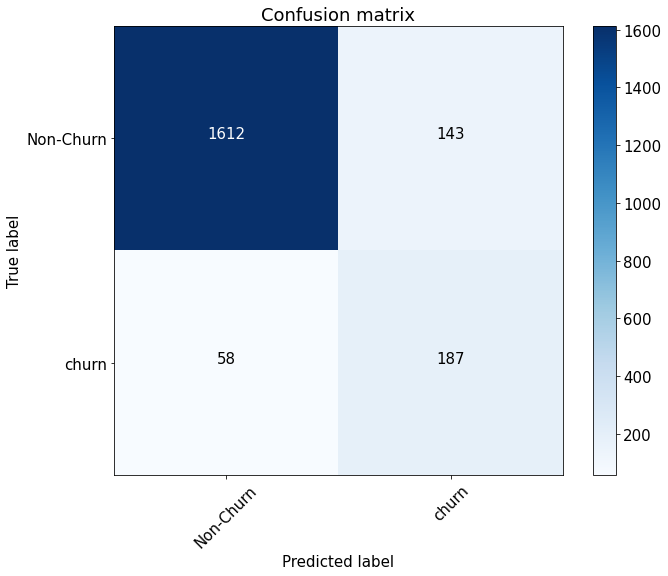

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9353264724693295

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
Повторить п.2, но используя уже не медиану, а max

In [ ]:
#вариант с median
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01249175, 0.        , 0.01256949, 0.09427064,
       0.        , 0.        , 0.        , 0.04221687, 0.03310001,
       0.14247551, 0.        , 0.01213228, 0.        , 0.        ,
       0.        , 0.        , 0.02100431, 0.        , 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [ ]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.000000,0.000000,0.000000,0.026570,0.000000,0.033578,0.000000,...,0.000000,0.000000,0.011554,0.025922,0.016846,0.000000,0.0,0.021003,0.000000,0.00000
1,u108690,0.0,0.0,0.006052,0.017382,0.017756,0.000000,0.042592,0.010434,0.072047,...,0.008526,0.000000,0.011245,0.000000,0.000000,0.039027,0.0,0.027840,0.078209,0.02932
2,u108339,0.0,0.0,0.000000,0.032090,0.015849,0.012489,0.131570,0.008137,0.078862,...,0.000000,0.024178,0.000000,0.037257,0.000000,0.012616,0.0,0.000000,0.022288,0.00000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("./drive/MyDrive/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.000000,0.000000,0.000000,0.026570,0.000000,0.033578,0.000000,...,0.000000,0.011554,0.025922,0.016846,0.000000,0.0,0.021003,0.000000,0.00000,0
1,u108690,0.0,0.0,0.006052,0.017382,0.017756,0.000000,0.042592,0.010434,0.072047,...,0.000000,0.011245,0.000000,0.000000,0.039027,0.0,0.027840,0.078209,0.02932,1
2,u108339,0.0,0.0,0.000000,0.032090,0.015849,0.012489,0.131570,0.008137,0.078862,...,0.024178,0.000000,0.037257,0.000000,0.012616,0.0,0.000000,0.022288,0.00000,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11948963, 0.04683932, 0.25778692, 0.34146488, 0.04244245,
       0.07150584, 0.10400926, 0.04275291, 0.12242144, 0.17195111])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.216642, F-Score=0.723, Precision=0.643, Recall=0.824


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1643  112]
 [  44  201]]


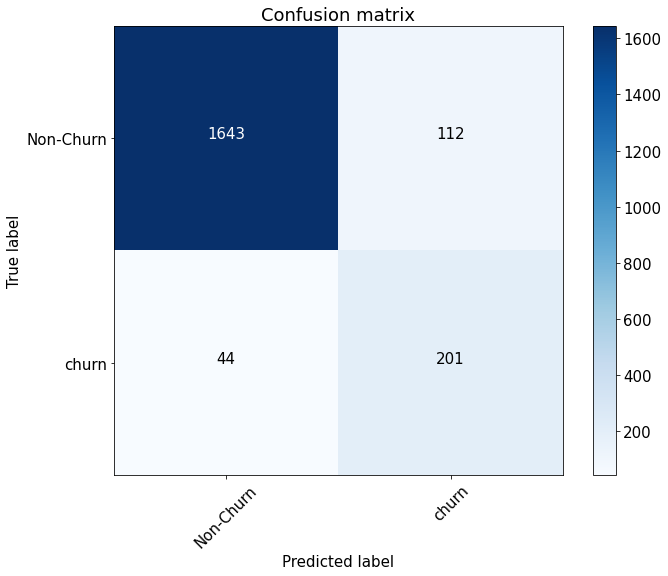

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9564602593174021

In [ ]:
#вариант с max
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.01115682, 0.02772529, 0.01530802, 0.0129403 , 0.06724957,
       0.28425887, 0.21591331, 0.02300769, 0.27316764, 0.35782465,
       0.04879408, 0.01360132, 0.03044837, 0.31296191, 0.23272154,
       0.32187146, 0.30040556, 0.16303335, 0.19325298, 0.21485974,
       0.05553982, 0.        , 0.17933431, 0.09051151, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [ ]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.348887,0.038977,0.100337,0.130171,0.053148,0.435760,0.264199,0.062090,0.103324,...,0.000000,0.000000,0.191383,0.135124,0.086209,0.117628,0.058083,0.246321,0.158112,0.181856
1,u108690,0.000000,0.014726,0.072066,0.108292,0.187084,0.000000,0.381796,0.077728,0.104101,...,0.056190,0.059476,0.016808,0.063044,0.053749,0.066639,0.023779,0.257472,0.198180,0.168700
2,u108339,0.033707,0.000000,0.043975,0.144140,0.054570,0.025338,0.191026,0.041784,0.286807,...,0.104601,0.185944,0.023996,0.328735,0.019464,0.062533,0.026277,0.024445,0.108431,0.032455


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("./drive/MyDrive/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.348887,0.038977,0.100337,0.130171,0.053148,0.435760,0.264199,0.062090,0.103324,...,0.000000,0.191383,0.135124,0.086209,0.117628,0.058083,0.246321,0.158112,0.181856,0
1,u108690,0.000000,0.014726,0.072066,0.108292,0.187084,0.000000,0.381796,0.077728,0.104101,...,0.059476,0.016808,0.063044,0.053749,0.066639,0.023779,0.257472,0.198180,0.168700,1
2,u108339,0.033707,0.000000,0.043975,0.144140,0.054570,0.025338,0.191026,0.041784,0.286807,...,0.185944,0.023996,0.328735,0.019464,0.062533,0.026277,0.024445,0.108431,0.032455,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00711443, 0.01432092, 0.47781311, 0.04013915, 0.08789815,
       0.13233469, 0.06326133, 0.02771854, 0.03967503, 0.15766111])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.282189, F-Score=0.731, Precision=0.667, Recall=0.808


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1656   99]
 [  48  197]]


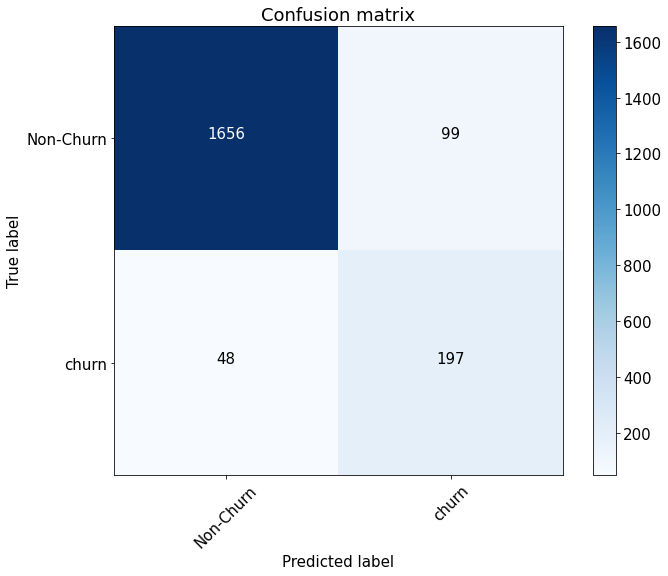

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc_score(y_test, preds)

0.9606581778010349

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
# vectorizer.fit_transform(news)

In [ ]:
news['title']

0        Заместитель председателяnправительства РФnСерг...
1        Матч 1/16 финала Кубка России по футболу был п...
2        Форвард «Авангарда» Томаш Заборский прокоммент...
3        Главный тренер «Кубани» Юрий Красножан прокомм...
4        Решением попечительского совета владивостокско...
                               ...                        
26995    Ученые Токийского университета морских наук и ...
26996    Главой кафедры отечественной истории XX века и...
26997    Американские ученые уточнили возраст расположе...
26998    За последние 50 лет тропический углеродный цик...
26999    У живших примерно 7 тыс. лет назад на территор...
Name: title, Length: 27000, dtype: object

In [ ]:
vectorizer.fit_transform(news['title'])

<27000x381161 sparse matrix of type '<class 'numpy.float64'>'
	with 6872877 stored elements in Compressed Sparse Row format>

In [ ]:
w_idf = vectorizer.idf_
w_idf.shape


(381161,)

In [ ]:
 vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., 'ちーはら', '仲良しぱくぱく', '黒人'], dtype=object)

не хватило меня, чтобы разобраться с idf

Метрики для варианта mean: Best Threshold=0.218463, F-Score=0.653, Precision=0.568, Recall=0.767, rocauc = 0.9353264724693295


Метрики для median: Best Threshold=0.216642, F-Score=0.723, Precision=0.643, Recall=0.824, rocauc = 0.9565

Метрики для max: Best Threshold=0.282189, F-Score=0.731, Precision=0.667, Recall=0.808, rocauc = 0.9607

Т.о. видим, что использование среднего показало худшие метрики. Разница между медианой и максимум небольшая в польщу максимума. Видимо, без взввешивания, усреднение наших векторов вводит неважные признаки в итоговое значение, как бы замусоривая его. Медиана и тем более максимум лучше "очищают" итоговый вектор, отбрасывая мусорные значения.
